<a href="https://colab.research.google.com/github/bibinjose/WQU_capstone/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Value-at-Risk (VaR) and Expected Shortfall (ES) in Commodities

Producer CFaR / VaR–ES Risk Engine

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import t as student_t, jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from numpy.linalg import eigh, cholesky

TICKERS = ["ZC=F", "ZS=F", "ZW=F"]
START = "2014-01-01"
END = None
USE_BASIS = False
BASIS_USD_PER_BU = {
    "ZC=F": 0.00,
    "ZS=F": 0.00,
    "ZW=F": 0.00,
}

EXPOSURE_BUSHELS = {"ZC=F": 1_000_000, "ZS=F": 600_000, "ZW=F": 800_000}

HORIZON_DAYS = 20
N_PATHS = 25_000
DIST = "student_t"
T_DF = 6
CONF_VAR = 0.99
CONF_ES = 0.975
CFAR_TARGET_FRACTION = 0.20
FUT_CONTRACT_SIZE = 5_000.0


data = yf.download(TICKERS, start=START, end=END, progress=False)
prices_fut = data["Close"].dropna(how="all")  # $/bu
if isinstance(prices_fut, pd.Series):
    prices_fut = prices_fut.to_frame()

if USE_BASIS:
    basis = pd.DataFrame({t: BASIS_USD_PER_BU.get(t, 0.0) for t in TICKERS}, index=prices_fut.index)
    prices_cash = (prices_fut + basis).dropna(how="any", axis=0)
else:
    prices_cash = prices_fut.copy()

returns = np.log(prices_fut / prices_fut.shift(1)).dropna()


print("LAST PRICES (cash) USD/bu")
print(prices_cash.iloc[-1].round(4))


/tmp/ipython-input-142517262.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKERS, start=START, end=END, progress=False)


LAST PRICES (cash) USD/bu
Ticker
ZC=F     418.25
ZS=F    1015.00
ZW=F     510.00
Name: 2025-10-01 00:00:00, dtype: float64


In [6]:
print("DESCRIPTIVE STATS (daily log returns x 1e2 %)")
desc = (returns * 100).describe().T
desc["skew"] = (returns * 100).skew()
desc["kurtosis_excess"] = (returns * 100).kurtosis()
print(desc.round(3))

DESCRIPTIVE STATS (daily log returns x 1e2 %)
         count   mean    std     min    25%    50%    75%     max   skew  \
Ticker                                                                     
ZC=F    2950.0 -0.001  1.603 -19.100 -0.867  0.000  0.878   7.718 -1.243   
ZS=F    2950.0 -0.008  1.326 -11.092 -0.753  0.036  0.738   6.426 -0.842   
ZW=F    2950.0 -0.005  1.953 -11.297 -1.216 -0.059  1.118  19.701  0.509   

        kurtosis_excess  
Ticker                   
ZC=F             15.765  
ZS=F              7.021  
ZW=F              5.076  


In [7]:
print("NORMALITY: Jarque–Bera p-values")
jb_rows = []
for c in returns.columns:
    stat, p = jarque_bera(returns[c].dropna())
    jb_rows.append((c, p))
print(pd.DataFrame(jb_rows, columns=["asset", "JB_pval"]).set_index("asset").round(4))


NORMALITY: Jarque–Bera p-values
       JB_pval
asset         
ZC=F       0.0
ZS=F       0.0
ZW=F       0.0


In [8]:
print("AUTOCORRELATION (Ljung–Box p-values at lags 5, 20)")
lb_rows = []
for c in returns.columns:
    lb5 = acorr_ljungbox(returns[c].dropna(), lags=[5], return_df=True)["lb_pvalue"].iloc[0]
    lb20 = acorr_ljungbox(returns[c].dropna(), lags=[20], return_df=True)["lb_pvalue"].iloc[0]
    lb_rows.append((c, lb5, lb20))
print(pd.DataFrame(lb_rows, columns=["asset", "LB_p(5)", "LB_p(20)"]).set_index("asset").round(4))


AUTOCORRELATION (Ljung–Box p-values at lags 5, 20)
       LB_p(5)  LB_p(20)
asset                   
ZC=F    0.1724    0.6749
ZS=F    0.0055    0.0077
ZW=F    0.0049    0.0075


In [10]:
print("CORRELATION MATRIX (daily returns)")
print(returns.corr().round(3))

print("ROLLING VOL (21d, annualized %)")
roll_vol = returns.rolling(21).std() * np.sqrt(252) * 100
print(roll_vol.iloc[-1].round(2))




CORRELATION MATRIX (daily returns)
Ticker   ZC=F   ZS=F   ZW=F
Ticker                     
ZC=F    1.000  0.520  0.529
ZS=F    0.520  1.000  0.327
ZW=F    0.529  0.327  1.000
ROLLING VOL (21d, annualized %) — last values
Ticker
ZC=F    24.24
ZS=F    13.38
ZW=F    25.07
Name: 2025-10-01 00:00:00, dtype: float64


In [12]:
print("TAIL CHECK: Empirical vs Gaussian 1% loss (in % return points)")
tail_rows = []
for c in returns.columns:
    r = returns[c].dropna()
    emp_q = np.quantile(r, 0.01) * 100
    mu, sig = r.mean(), r.std()
    gauss_q = (mu + sig * np.quantile(np.random.normal(size=1_000_000), 0.01)) * 100
    tail_rows.append((c, emp_q, gauss_q))
print(pd.DataFrame(tail_rows, columns=["asset", "empirical_1pct", "gaussian_1pct"]).set_index("asset").round(3))

TAIL CHECK: Empirical vs Gaussian 1% loss (in % return points)
       empirical_1pct  gaussian_1pct
asset                               
ZC=F           -4.320         -3.729
ZS=F           -3.491         -3.094
ZW=F           -4.259         -4.547


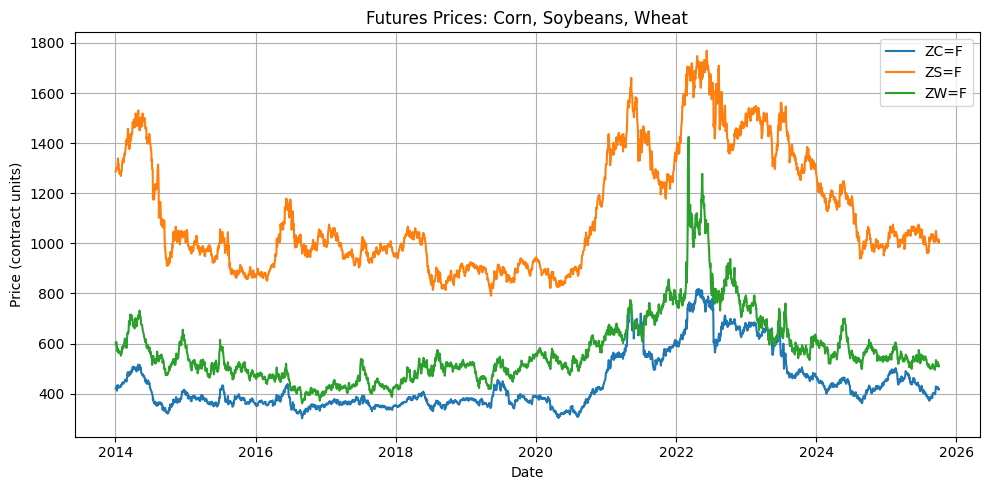

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
for t in TICKERS:
    plt.plot(prices_fut.index, prices_fut[t])
plt.title("Futures Prices: Corn, Soybeans, Wheat")
plt.xlabel("Date")
plt.ylabel("Price (contract units)")
plt.grid(True)
plt.legend(TICKERS)
plt.tight_layout()
plt.show()

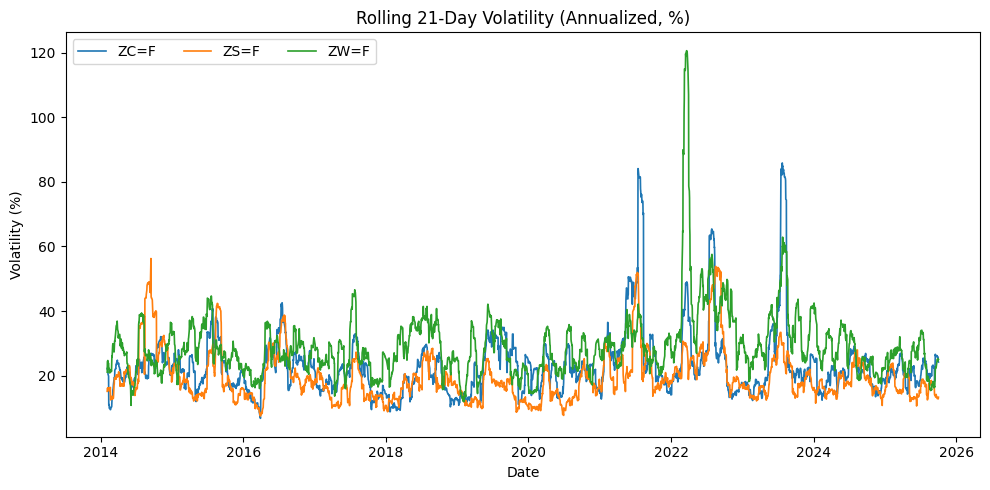

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
rv = returns.rolling(21).std() * (252**0.5) * 100
for c in rv.columns:
    ax.plot(rv.index, rv[c], label=c, linewidth=1.2)
ax.set_title("Rolling 21-Day Volatility (Annualized, %)")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility (%)")
ax.legend(ncol=len(rv.columns))
plt.tight_layout()
plt.show()


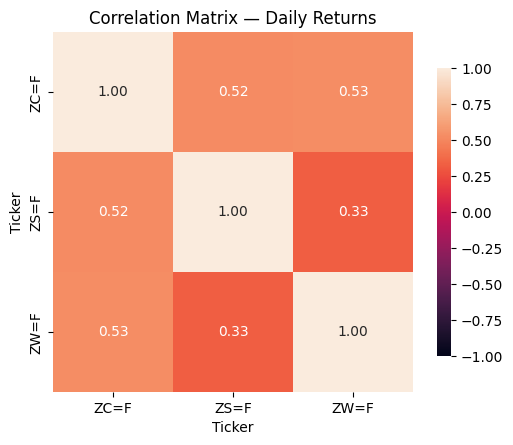

In [17]:
fig, ax = plt.subplots(figsize=(5.5, 4.5))
corr = returns.corr()
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, square=True, ax=ax, cbar_kws={"shrink":0.8})
ax.set_title("Correlation Matrix — Daily Returns")
plt.tight_layout()
plt.show()

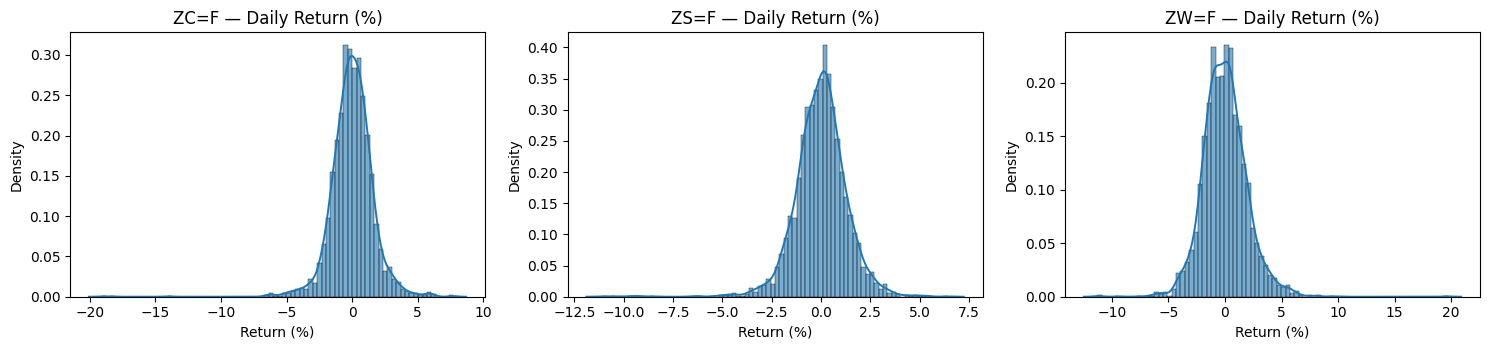

In [18]:
cols = returns.columns.tolist()
n = len(cols)
rows = 1 if n <= 3 else int(np.ceil(n/2))
cols_per_row = min(3, n)
fig, axes = plt.subplots(rows, cols_per_row, figsize=(5*cols_per_row, 3.6*rows))
axes = np.atleast_1d(axes).ravel()

for i, name in enumerate(cols):
    r = returns[name].dropna() * 100  # %
    sns.histplot(r, bins=80, stat="density", ax=axes[i], alpha=0.6)
    sns.kdeplot(r, ax=axes[i], linewidth=1.4)
    axes[i].set_title(f"{name} — Daily Return (%)")
    axes[i].set_xlabel("Return (%)"); axes[i].set_ylabel("Density")
for j in range(i+1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

In [19]:
def plot_pnl_dist(pnl, title, conf_var=CONF_VAR, conf_es=CONF_ES):
    fig, ax = plt.subplots(figsize=(8, 4.5))
    sns.histplot(pnl/1e6, bins=200, ax=ax, alpha=0.7)  # in $mm
    q_var = np.quantile(pnl, 1-conf_var)/1e6
    q_es  = np.quantile(pnl, 1-conf_es)/1e6
    es_mean = pnl[pnl <= np.quantile(pnl, 1-conf_es)].mean()/1e6
    ax.axvline(q_var, linestyle="--", linewidth=1.5, label=f"VaR {int(conf_var*100)}% = {q_var:.2f} mm")
    ax.axvline(es_mean, linestyle="-.", linewidth=1.5, label=f"ES {int(conf_es*100)}% = {es_mean:.2f} mm")
    ax.set_title(title)
    ax.set_xlabel("Portfolio P&L (USD mm)")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_pnl_dist(pnl_unhedged, "Unhedged Portfolio P&L Distribution")
plot_pnl_dist(pnl_hedged,   "Hedged Portfolio P&L Distribution")

NameError: name 'pnl_unhedged' is not defined